In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score

from processor import NLProcessor
from trainer   import Trainer
from ranker    import LossRanker

from fixer import OracleFixer

from tqdm import tnrange

In [4]:
corrupt_rate           = 0.1

In [5]:
processor = NLProcessor()
processor.load_spam()

In [6]:
guess_scores  = []
for seed in tnrange(15):

    X_train,  ycrptd = processor.corrupt_random(seed, corrupt_rate)
    trainer          = Trainer(X_train,  ycrptd, processor.X_test, processor.y_test)
    ranker           = LossRanker(trainer)
    fixer            = OracleFixer(ycrptd != processor.y_train)
    
    trainer.train()
    
    guess_scores.append([0])
    
    # Let us make some rounds of correction of sample based on training loss
    correction_rounds = int(2 * X_train.shape[0] * corrupt_rate)
    
    for i in range(correction_rounds):
        rank = ranker.rank()
        correct_guess = fixer.fix(trainer, rank)
        if correct_guess:
            trainer.train()
            
        guess_scores[-1].append(guess_scores[-1][-1] + correct_guess)

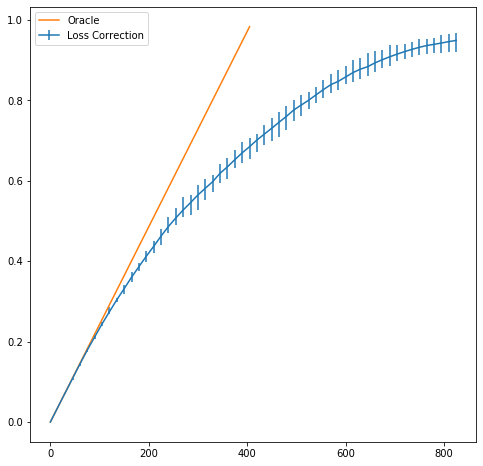

In [7]:
guess_array  = np.array(guess_scores)

guess_means = np.mean(guess_array[:, ::15]/(X_train.shape[0] * corrupt_rate), axis = 0)
guess_mins  = np.min(guess_array[:, ::15]/(X_train.shape[0] * corrupt_rate), axis  = 0)
guess_maxs  = np.max(guess_array[:, ::15]/(X_train.shape[0] * corrupt_rate), axis  = 0)
stacked      = np.stack([guess_means -guess_mins, guess_maxs- guess_means])

plt.figure(figsize=(8,8))
plt.errorbar(range(len(guess_array[0]))[::15], guess_means, yerr = stacked, label = 'Loss Correction')
plt.plot(range(len(guess_array[0]))[:int(X_train.shape[0] * corrupt_rate):15], 
         np.linspace(0, 1, int(X_train.shape[0] * corrupt_rate))[::15],  label = 'Oracle')
plt.legend()
plt.show()

In [8]:
guess_means_loss = np.mean(guess_array/(X_train.shape[0] * corrupt_rate), axis = 0)

In [9]:
%store guess_means_loss

Stored 'guess_means_loss' (ndarray)
